In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Optional, Union, List, Dict
from pathlib import Path
from dataclasses import dataclass, field
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
import joblib
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')



# Configurazione per grafici migliori
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


In [9]:
@dataclass
class SampleConfig:
    """Configurazione per un singolo campionamento."""
    name: str
    n_samples_per_class: int
    random_state: int = 42


@dataclass
class DatasetInfo:
    """Informazioni sul dataset."""
    n_samples: int
    n_features: int
    class_distribution: Dict[int, int]
    features_columns: List[str]
    labels_columns: List[str]


@dataclass
class DataLoader:
    features_path: Union[str, Path]
    labels_path: Union[str, Path]
    _features_df_cache: Optional[pd.DataFrame] = field(default=None, init=False, repr=False)
    _labels_df_cache: Optional[pd.DataFrame] = field(default=None, init=False, repr=False)
    
    def __post_init__(self):
        """Converte i path in oggetti Path e verifica che esistano."""
        self.features_path = Path(self.features_path)
        self.labels_path = Path(self.labels_path)
        
        if not self.features_path.exists():
            raise FileNotFoundError(f"Features file not found: {self.features_path}")
        if not self.labels_path.exists():
            raise FileNotFoundError(f"Labels file not found: {self.labels_path}")
    
    def load_full_data(self, use_cache: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Carica tutti i dati senza campionamento.
        
        Args:
            use_cache: Se True, usa i dati in cache se disponibili
            
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: features_df, labels_df
        """
        if use_cache and self._features_df_cache is not None and self._labels_df_cache is not None:
            return self._features_df_cache, self._labels_df_cache
        
        features_df = pd.read_parquet(self.features_path)
        labels_df = pd.read_parquet(self.labels_path)
        
        # Verifica che abbiano lo stesso numero di righe
        if len(features_df) != len(labels_df):
            raise ValueError(f"Features and labels have different lengths: "
                           f"{len(features_df)} vs {len(labels_df)}")
        
        if use_cache:
            self._features_df_cache = features_df
            self._labels_df_cache = labels_df
        
        return features_df, labels_df
    
    def clear_cache(self) -> None:
        """Pulisce la cache dei dati."""
        self._features_df_cache = None
        self._labels_df_cache = None
    
    def load_balanced_sample(self, n_samples_per_class: int, 
                           random_state: int = 42,
                           use_cache: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Carica un campione bilanciato dei dati.
            
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: features_df campionate, labels_df campionate
        """
        # Carica i dati completi
        features_df_full, labels_df_full = self.load_full_data(use_cache=use_cache)
        
        # Ottieni gli indici campionati in modo bilanciato
        sampled_indices = self._get_balanced_indices(
            labels_df_full, 
            n_samples_per_class, 
            random_state
        )
        
        # Campiona i dati
        features_df = features_df_full.loc[sampled_indices].reset_index(drop=True)
        labels_df = labels_df_full.loc[sampled_indices].reset_index(drop=True)
        
        return features_df, labels_df
    
    def load_balanced_sample_memory_efficient(self, n_samples_per_class: int, 
                                            random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Versione memory-efficient che libera la memoria dopo il campionamento.
        
        Args:
            n_samples_per_class: Numero di campioni per ogni classe
            random_state: Seed per la riproducibilità
            
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: features_df campionate, labels_df campionate
        """
        # Carica i dati completi (senza cache)
        features_df_full = pd.read_parquet(self.features_path)
        labels_df_full = pd.read_parquet(self.labels_path)
        
        # Ottieni gli indici campionati
        sampled_indices = self._get_balanced_indices(
            labels_df_full, 
            n_samples_per_class, 
            random_state
        )
        
        # Campiona i dati
        features_df = features_df_full.loc[sampled_indices].reset_index(drop=True)
        labels_df = labels_df_full.loc[sampled_indices].reset_index(drop=True)
        
        # Libera la memoria
        del features_df_full, labels_df_full, sampled_indices
        
        return features_df, labels_df
    

    
    def _get_balanced_indices(self, labels_df: pd.DataFrame, 
                            n_samples_per_class: int, 
                            random_state: int) -> pd.Index:
        """
        Ottiene gli indici per un campionamento bilanciato.
        
        Args:
            labels_df: DataFrame delle labels
            n_samples_per_class: Numero di campioni per classe
            random_state: Seed per la riproducibilità
            
        Returns:
            pd.Index: Indici campionati
        """
        # Usa la prima colonna per il groupby (assumendo sia la colonna delle classi)
        label_column = labels_df.iloc[:, 0]
        
        # Verifica che ci siano abbastanza campioni per ogni classe
        class_counts = label_column.value_counts()
        for class_label, count in class_counts.items():
            if count < n_samples_per_class:
                raise ValueError(f"Class {class_label} has only {count} samples, "
                               f"but {n_samples_per_class} requested")
        
        # Campiona gli indici
        sampled_indices = (
            labels_df.groupby(label_column)
            .apply(lambda x: x.sample(n=n_samples_per_class, random_state=random_state))
            .index.get_level_values(1)
        )
        
        return sampled_indices

In [10]:
# Carico un dataset più piccolo a classi bilanciate per la ricerca degli iperparametri 
# e uno più esteso per ri-trainare il modello con i parametri ottimali trovati

loader = DataLoader(
    features_path='processed_data/binary_classification/data_w_features/combined_features.parquet',
    labels_path='processed_data/binary_classification/data_w_features/labels_binary_stats_features_only.parquet'
)

# Esempio 1: Carica 40k campioni bilanciati (20k per classe) per training
features_df, labels_df = loader.load_balanced_sample_memory_efficient(n_samples_per_class=20000)
print(f"Training set shape: features={features_df.shape}, labels={labels_df.shape}")

# Esempio 2: Carica 500k campioni bilanciati (250k per classe) per fit finale
features_df_to_finalize, labels_df_to_finalize = loader.load_balanced_sample_memory_efficient(
    n_samples_per_class=250000
)
print(f"Final set shape: features={features_df_to_finalize.shape}, labels={labels_df_to_finalize.shape}")
print(f"Class distribution in dev set set: {labels_df.iloc[:, 0].value_counts()}")
print(f"Class distribution in final set: {labels_df_to_finalize.iloc[:, 0].value_counts()}")

Training set shape: features=(40000, 134), labels=(40000, 1)
Final set shape: features=(500000, 134), labels=(500000, 1)
Class distribution in dev set set: 0
0    20000
1    20000
Name: count, dtype: int64
Class distribution in final set: 0
0    250000
1    250000
Name: count, dtype: int64


In [11]:
def _load_catboost_model(model_path=str):
        """Carica il modello CatBoost dal percorso specificato"""
        try:
            model = CatBoostClassifier()
            model.load_model(str(model_path))
            print(f"Modello caricato con successo da: {model_path}")
            return model
        except Exception as e:
            print(f"Errore nel caricamento del modello: {e}")
            raise


catboost_model_path = r"./models/catboost_test120625_1946/catboost_trained_on_full_data_model_v1.cbm"
catboost_scaler_path = "./models/catboost_test120625_1946/catboost_trained_on_full_data_model_v1_scaler.joblib"

xg_boost_model_path = "./models/xgboost/xgboost_production_model_v1.joblib"
xg_boost_scaler_path = "./models/xgboost/xgboost_production_model_v1_scaler.joblib"

In [12]:

# 1. CARICAMENTO MODELLI E SCALER
print("Caricamento modelli e scaler...")

# Carica CatBoost (assumendo che la funzione load_catboost_model sia definita)
catboost_model_final = _load_catboost_model(catboost_model_path)

# Carica gli scaler (assumendo che i path siano definiti)
try:
    catboost_scaler = joblib.load(catboost_scaler_path)
    print("✓ CatBoost scaler caricato")
except FileNotFoundError:
    print("⚠ CatBoost scaler non trovato, verrà creato uno nuovo")

    catboost_scaler = StandardScaler()

# Carica XGBoost (se il modello è disponibile)
xg_boost_model_final = None
try:
    xg_boost_model_final = joblib.load(xg_boost_model_path) 
    print("✓ XGBoost modello caricato")
except FileNotFoundError:
    print("⚠ XGBoost modello non trovato")
    xg_boost_model_final = None

# Se XGBoost dovesse essere riattivato in futuro
xgboost_scaler = None
if xg_boost_model_final is not None:
    try:
        xgboost_scaler = joblib.load(xg_boost_scaler_path)
        print("✓ XGBoost scaler caricato")
    except FileNotFoundError:
        print("⚠ XGBoost scaler non trovato")
        xgboost_scaler = StandardScaler()
# Funzione per verificare se i modelli sono stati caricati correttamente
def check_models_loaded():  
    if catboost_model_final is None:
        print("⚠ CatBoost model non caricato correttamente.")
    else:
        print("✓ CatBoost model caricato correttamente.")

    if xg_boost_model_final is None:
        print("⚠ XGBoost model non caricato correttamente.")
    else:
        print("✓ XGBoost model caricato correttamente.")

Caricamento modelli e scaler...
Modello caricato con successo da: ./models/catboost_test120625_1946/catboost_trained_on_full_data_model_v1.cbm
✓ CatBoost scaler caricato
✓ XGBoost modello caricato
✓ XGBoost scaler caricato



Preparazione dati...
Train set: (400000, 134)
Test set: (100000, 134)

VALUTAZIONE MODELLI CON SOGLIA STANDARD (0.5)

CatBoost - Soglia: 0.500
Accuracy:  0.8619
Precision: 0.8465
Recall:    0.8841
F1-Score:  0.8649
AUC-ROC:   0.9370

XGBoost - Soglia: 0.500
Accuracy:  0.8876
Precision: 0.8715
Recall:    0.9093
F1-Score:  0.8900
AUC-ROC:   0.9572

Voting Classifier - Soglia: 0.500
Accuracy:  0.8746
Precision: 0.8478
Recall:    0.9132
F1-Score:  0.8793
AUC-ROC:   0.9476

OTTIMIZZAZIONE SOGLIA PER MASSIMIZZARE RECALL

CatBoost:
Soglia ottimale: 0.500
Recall sul train: 0.8980

CatBoost (Ottimizzato) - Soglia: 0.500
Accuracy:  0.8619
Precision: 0.8465
Recall:    0.8841
F1-Score:  0.8649
AUC-ROC:   0.9370

XGBoost:
Soglia ottimale: 0.500
Recall sul train: 0.9096

XGBoost (Ottimizzato) - Soglia: 0.500
Accuracy:  0.8876
Precision: 0.8715
Recall:    0.9093
F1-Score:  0.8900
AUC-ROC:   0.9572

Voting:
Soglia ottimale: 0.500
Recall sul train: 0.9159

Voting (Ottimizzato) - Soglia: 0.500
Accuracy

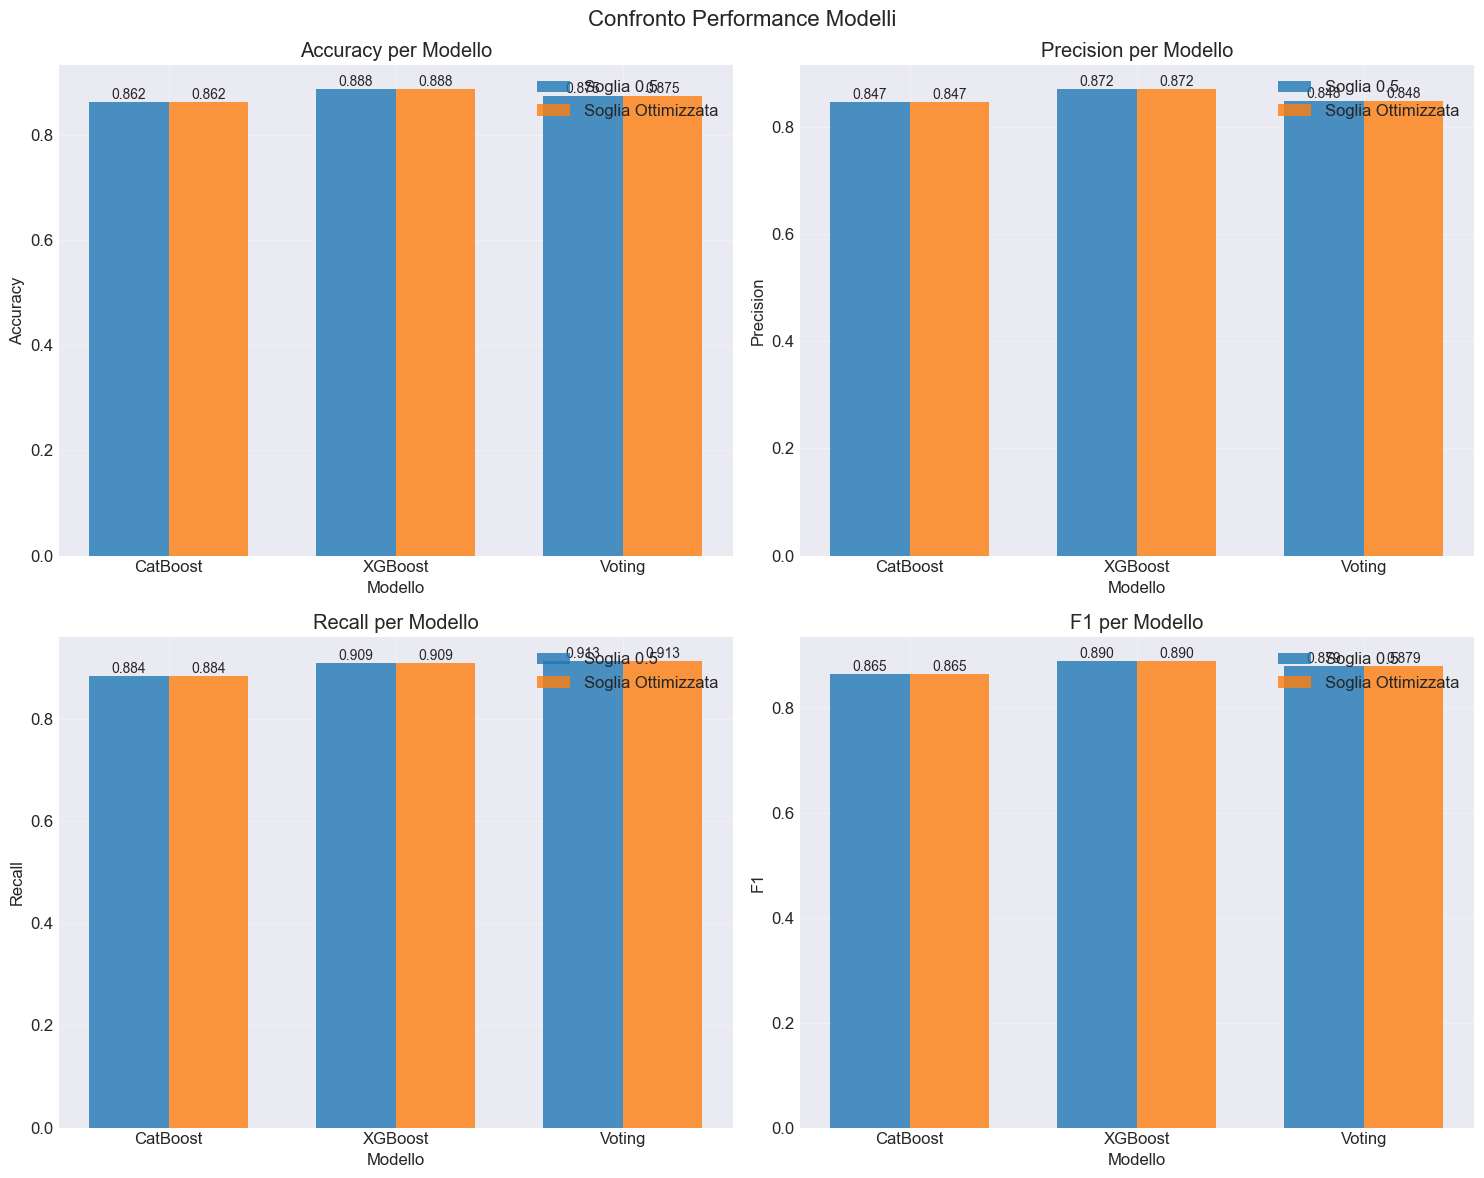

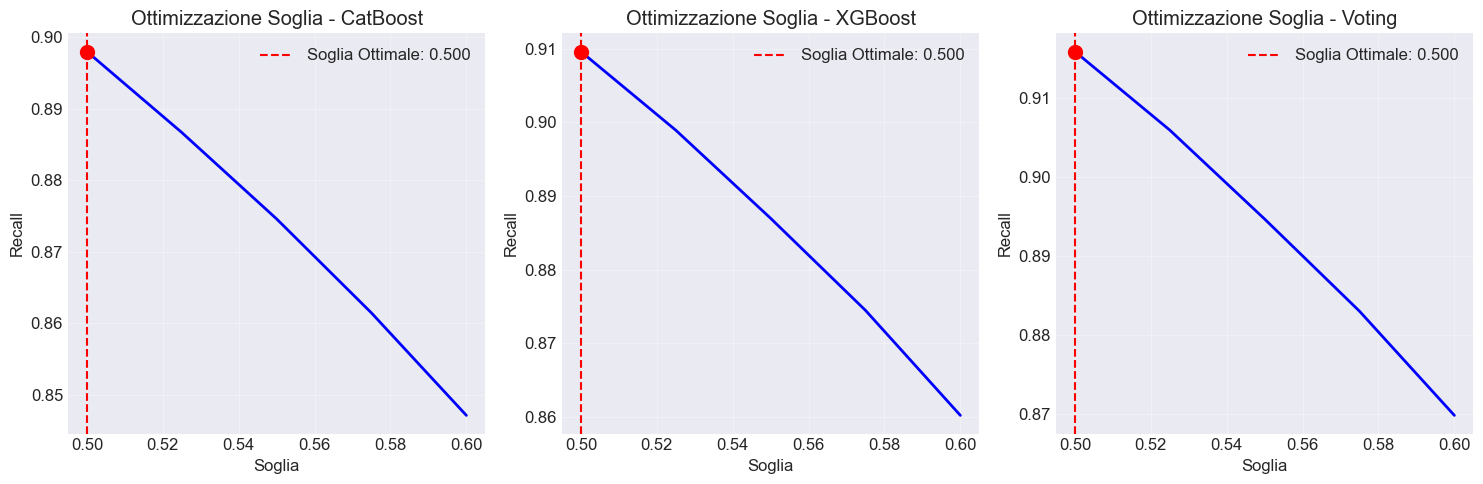

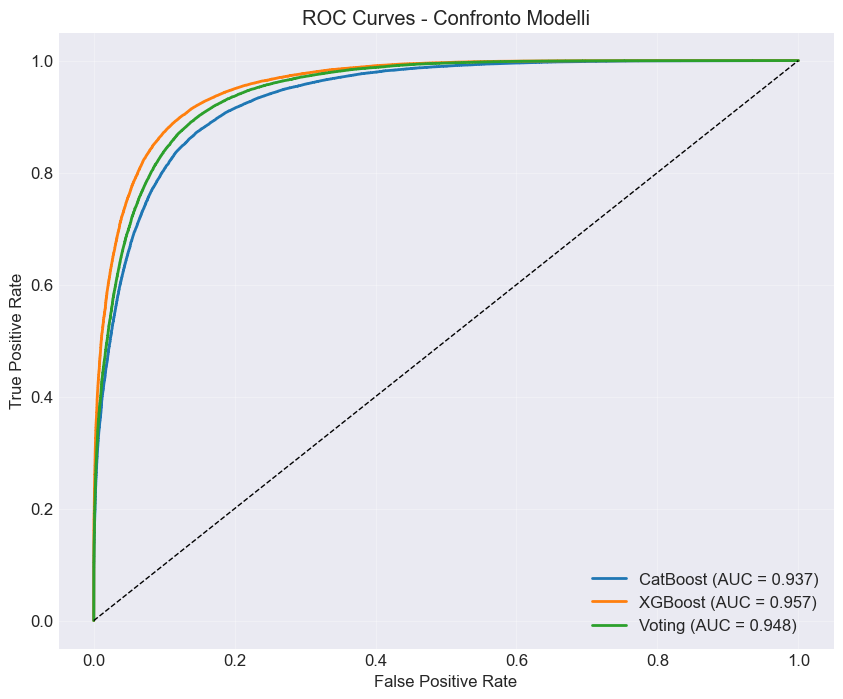

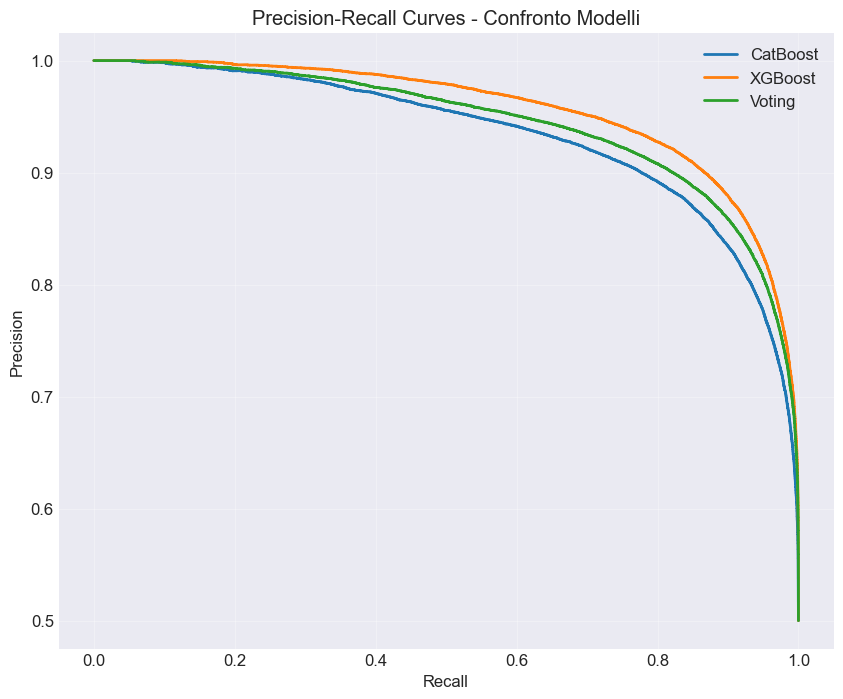

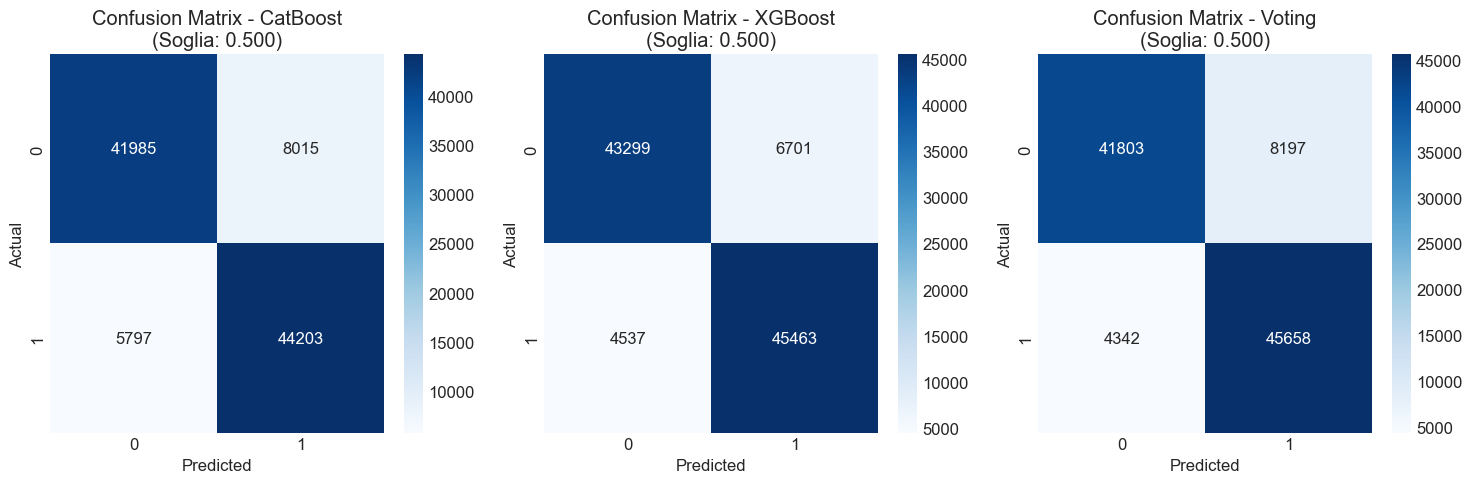


REPORT FINALE - CONFRONTO MODELLI

                 Modello Accuracy Precision Recall F1-Score AUC-ROC
  CatBoost (Soglia 0.5)   0.8619    0.8465 0.8841   0.8649  0.9370
CatBoost (Soglia 0.500)   0.8619    0.8465 0.8841   0.8649  0.9370
   XGBoost (Soglia 0.5)   0.8876    0.8715 0.9093   0.8900  0.9572
 XGBoost (Soglia 0.500)   0.8876    0.8715 0.9093   0.8900  0.9572
    Voting (Soglia 0.5)   0.8746    0.8478 0.9132   0.8793  0.9476
  Voting (Soglia 0.500)   0.8746    0.8478 0.9132   0.8793  0.9476

MIGLIORAMENTO DEL RECALL CON OTTIMIZZAZIONE SOGLIA

CatBoost:
  Recall prima: 0.8841
  Recall dopo:  0.8841
  Miglioramento: +0.0%

XGBoost:
  Recall prima: 0.9093
  Recall dopo:  0.9093
  Miglioramento: +0.0%

Voting:
  Recall prima: 0.9132
  Recall dopo:  0.9132
  Miglioramento: +0.0%

SALVATAGGIO CONFIGURAZIONE FINALE
✓ Voting Classifier salvato in './models/voting/voting_classifier_final.pkl
✓ Configurazione salvata in './models/voting/model_config.pkl
✓ Soglia ottimale per Recall: 0.

In [26]:

# 2. CUSTOM VOTING CLASSIFIER
class MaxProbVotingClassifier(BaseEstimator, ClassifierMixin):
    """
    Voting Classifier che seleziona la classe con la probabilità più alta.
    In caso di pareggio, privilegia CatBoost.
    """
    def __init__(self, estimators, scalers=None):
        self.estimators = estimators
        self.scalers = scalers if scalers else {}
        self.classes_ = np.array([0, 1])
        
    def fit(self, X, y):
        # Fit degli scaler se necessario
        for name, scaler in self.scalers.items():
            if scaler is not None and not hasattr(scaler, 'mean_'):
                scaler.fit(X)
        return self
    
    def predict_proba(self, X):
        """Calcola le probabilità medie o massime per ogni classe"""
        probas = []
        
        for name, model in self.estimators:
            if model is None:
                continue
                
            # Applica lo scaler se disponibile
            X_scaled = X
            if name in self.scalers and self.scalers[name] is not None:
                X_scaled = self.scalers[name].transform(X)
            
            # Ottieni le probabilità
            proba = model.predict_proba(X_scaled)
            probas.append((name, proba))
        
        if not probas:
            raise ValueError("Nessun modello disponibile per le predizioni")
        
        # Per ogni sample, prendi la probabilità massima per la classe positiva
        n_samples = X.shape[0]
        final_probas = np.zeros((n_samples, 2))
        
        for i in range(n_samples):
            max_prob_class_1 = -1
            best_model = None
            
            for name, proba in probas:
                if proba[i, 1] > max_prob_class_1:
                    max_prob_class_1 = proba[i, 1]
                    best_model = name
                    final_probas[i] = proba[i]
                elif proba[i, 1] == max_prob_class_1 and name == 'catboost':
                    # In caso di pareggio, privilegia CatBoost
                    best_model = name
                    final_probas[i] = proba[i]
        
        return final_probas
    
    def predict(self, X):
        """Predizione basata sulle probabilità"""
        probas = self.predict_proba(X)
        return (probas[:, 1] >= 0.5).astype(int)

# 3. PREPARAZIONE DATI
print("\nPreparazione dati...")
X_train, X_test, y_train, y_test = train_test_split(
    features_df_to_finalize, 
    labels_df_to_finalize,
    test_size=0.2, 
    random_state=42, 
    stratify=labels_df_to_finalize
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
#print(f"Distribuzione classi train: {np.bincount(y_train)}")
#print(f"Distribuzione classi test: {np.bincount(y_test)}")

# 4. CREAZIONE VOTING CLASSIFIER
estimators = []
scalers = {}

if catboost_model_final is not None:
    estimators.append(('catboost', catboost_model_final))
    scalers['catboost'] = catboost_scaler

if xg_boost_model_final is not None:
    estimators.append(('xgboost', xg_boost_model_final))
    scalers['xgboost'] = xgboost_scaler

voting_clf = MaxProbVotingClassifier(estimators=estimators, scalers=scalers)
voting_clf.fit(X_train, y_train)

# 5. FUNZIONE PER TROVARE SOGLIA OTTIMALE
def find_optimal_threshold(model, X, y, metric='f1', conservative=False):
    """
    Trova la soglia ottimale per massimizzare una metrica.
    Se conservative=True, in caso di pareggio prende la soglia più bassa (più conservativa).
    """
    probas = model.predict_proba(X)[:, 1]
    thresholds = np.linspace(0.5, 0.6, 5)
    
    scores = []
    for threshold in thresholds:
        y_pred = (probas >= threshold).astype(int)
        
        if metric == 'recall':
            score = recall_score(y, y_pred)
        elif metric == 'precision':
            score = precision_score(y, y_pred)
        elif metric == 'f1':
            score = f1_score(y, y_pred)
        else:
            raise ValueError(f"Metrica non supportata: {metric}")
        
        scores.append(score)
    
    scores = np.array(scores)
    
    if conservative:
        # Trova il primo threshold che massimizza la metrica
        optimal_idx = np.where(scores == scores.max())[0][0]
    else:
        # Trova l'ultimo threshold che massimizza la metrica
        optimal_idx = np.where(scores == scores.max())[0][-1]
    
    optimal_threshold = thresholds[optimal_idx]
    optimal_score = scores[optimal_idx]
    
    return optimal_threshold, optimal_score, thresholds, scores

# 6. VALUTAZIONE MODELLI
def evaluate_model(model, X_test, y_test, model_name, threshold=0.5):
    """Valuta un modello con metriche multiple"""
    probas = model.predict_proba(X_test)[:, 1]
    y_pred = (probas >= threshold).astype(int)
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, probas)
    }
    
    print(f"\n{model_name} - Soglia: {threshold:.3f}")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1']:.4f}")
    print(f"AUC-ROC:   {metrics['auc']:.4f}")
    
    return metrics, y_pred, probas

# Valutazione con soglia standard (0.5)
print("\n" + "="*50)
print("VALUTAZIONE MODELLI CON SOGLIA STANDARD (0.5)")
print("="*50)

results_standard = {}

# CatBoost
if catboost_model_final is not None:
    X_test_scaled_cb = catboost_scaler.transform(X_test) if catboost_scaler else X_test
    metrics, y_pred, probas = evaluate_model(
        catboost_model_final, X_test_scaled_cb, y_test, "CatBoost"
    )
    results_standard['CatBoost'] = {'metrics': metrics, 'y_pred': y_pred, 'probas': probas}

# XGBoost (se disponibile)
if xg_boost_model_final is not None:
    X_test_scaled_xgb = xgboost_scaler.transform(X_test) if xgboost_scaler else X_test
    metrics, y_pred, probas = evaluate_model(
        xg_boost_model_final, X_test_scaled_xgb, y_test, "XGBoost"
    )
    results_standard['XGBoost'] = {'metrics': metrics, 'y_pred': y_pred, 'probas': probas}

# Voting Classifier
metrics, y_pred, probas = evaluate_model(voting_clf, X_test, y_test, "Voting Classifier")
results_standard['Voting'] = {'metrics': metrics, 'y_pred': y_pred, 'probas': probas}

# 7. OTTIMIZZAZIONE SOGLIA PER RECALL
print("\n" + "="*50)
print("OTTIMIZZAZIONE SOGLIA PER MASSIMIZZARE RECALL")
print("="*50)

results_optimized = {}

# Trova soglie ottimali per ogni modello
for model_name, model in [('CatBoost', catboost_model_final), 
                          ('XGBoost', xg_boost_model_final),
                          ('Voting', voting_clf)]:
    if model is None:
        continue
    
    if model_name == 'CatBoost':
        X_val = catboost_scaler.transform(X_train) if catboost_scaler else X_train
        X_test_model = catboost_scaler.transform(X_test) if catboost_scaler else X_test
    elif model_name == 'XGBoost':
        X_val = xgboost_scaler.transform(X_train) if xgboost_scaler else X_train
        X_test_model = xgboost_scaler.transform(X_test) if xgboost_scaler else X_test
    else:  # Voting
        X_val = X_train
        X_test_model = X_test
    
    optimal_threshold, optimal_recall, thresholds, scores = find_optimal_threshold(
        model, X_val, y_train, metric='recall', conservative=True
    )
    
    print(f"\n{model_name}:")
    print(f"Soglia ottimale: {optimal_threshold:.3f}")
    print(f"Recall sul train: {optimal_recall:.4f}")
    
    # Valuta con soglia ottimale
    metrics, y_pred, probas = evaluate_model(
        model, X_test_model, y_test, f"{model_name} (Ottimizzato)", optimal_threshold
    )
    
    results_optimized[model_name] = {
        'metrics': metrics,
        'y_pred': y_pred,
        'probas': probas,
        'optimal_threshold': optimal_threshold,
        'threshold_scores': (thresholds, scores)
    }

# 8. VISUALIZZAZIONI

# 8.1 Confronto metriche
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Confronto Performance Modelli', fontsize=16)

# Prepara dati per confronto
models = list(results_standard.keys())
metrics_names = ['accuracy', 'precision', 'recall', 'f1']

for idx, metric in enumerate(metrics_names):
    ax = axes[idx//2, idx%2]
    
    standard_scores = [results_standard[m]['metrics'][metric] for m in models]
    optimized_scores = [results_optimized[m]['metrics'][metric] 
                       for m in models if m in results_optimized]
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, standard_scores, width, label='Soglia 0.5', alpha=0.8)
    bars2 = ax.bar(x + width/2, optimized_scores, width, label='Soglia Ottimizzata', alpha=0.8)
    
    ax.set_xlabel('Modello')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} per Modello')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Aggiungi valori sulle barre
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 8.2 Curve di ottimizzazione soglia
fig, axes = plt.subplots(1, len(results_optimized), figsize=(15, 5))
if len(results_optimized) == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(results_optimized.items()):
    thresholds, scores = result['threshold_scores']
    optimal_threshold = result['optimal_threshold']
    
    ax = axes[idx]
    ax.plot(thresholds, scores, 'b-', linewidth=2)
    ax.axvline(optimal_threshold, color='red', linestyle='--', 
               label=f'Soglia Ottimale: {optimal_threshold:.3f}')
    ax.scatter([optimal_threshold], [scores[np.where(thresholds == optimal_threshold)[0][0]]], 
               color='red', s=100, zorder=5)
    
    ax.set_xlabel('Soglia')
    ax.set_ylabel('Recall')
    ax.set_title(f'Ottimizzazione Soglia - {model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8.3 ROC Curves
plt.figure(figsize=(10, 8))

for model_name in results_standard.keys():
    if model_name in results_optimized:
        probas = results_optimized[model_name]['probas']
    else:
        probas = results_standard[model_name]['probas']
    
    fpr, tpr, _ = roc_curve(y_test, probas)
    auc = roc_auc_score(y_test, probas)
    
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Confronto Modelli')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 8.4 Precision-Recall Curves
plt.figure(figsize=(10, 8))

for model_name in results_standard.keys():
    if model_name in results_optimized:
        probas = results_optimized[model_name]['probas']
    else:
        probas = results_standard[model_name]['probas']
    
    precision, recall, _ = precision_recall_curve(y_test, probas)
    
    plt.plot(recall, precision, linewidth=2, label=model_name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Confronto Modelli')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 8.5 Confusion Matrices
n_models = len(results_optimized)
fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
if n_models == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(results_optimized.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=True)
    ax.set_title(f'Confusion Matrix - {model_name}\n(Soglia: {result["optimal_threshold"]:.3f})')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()



# 9. REPORT FINALE
print("\n" + "="*50)
print("REPORT FINALE - CONFRONTO MODELLI")
print("="*50)

# Tabella riassuntiva
summary_data = []

for model_name in results_standard.keys():
    # Risultati con soglia standard
    std_metrics = results_standard[model_name]['metrics']
    row = {
        'Modello': f"{model_name} (Soglia 0.5)",
        'Accuracy': f"{std_metrics['accuracy']:.4f}",
        'Precision': f"{std_metrics['precision']:.4f}",
        'Recall': f"{std_metrics['recall']:.4f}",
        'F1-Score': f"{std_metrics['f1']:.4f}",
        'AUC-ROC': f"{std_metrics['auc']:.4f}"
    }
    summary_data.append(row)
    
    # Risultati con soglia ottimizzata
    if model_name in results_optimized:
        opt_metrics = results_optimized[model_name]['metrics']
        opt_threshold = results_optimized[model_name]['optimal_threshold']
        row = {
            'Modello': f"{model_name} (Soglia {opt_threshold:.3f})",
            'Accuracy': f"{opt_metrics['accuracy']:.4f}",
            'Precision': f"{opt_metrics['precision']:.4f}",
            'Recall': f"{opt_metrics['recall']:.4f}",
            'F1-Score': f"{opt_metrics['f1']:.4f}",
            'AUC-ROC': f"{opt_metrics['auc']:.4f}"
        }
        summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

# Miglioramento del Recall
print("\n" + "="*50)
print("MIGLIORAMENTO DEL RECALL CON OTTIMIZZAZIONE SOGLIA")
print("="*50)

for model_name in results_standard.keys():
    if model_name in results_optimized:
        recall_before = results_standard[model_name]['metrics']['recall']
        recall_after = results_optimized[model_name]['metrics']['recall']
        improvement = (recall_after - recall_before) / recall_before * 100
        
        print(f"\n{model_name}:")
        print(f"  Recall prima: {recall_before:.4f}")
        print(f"  Recall dopo:  {recall_after:.4f}")
        print(f"  Miglioramento: {improvement:+.1f}%")

# 10. SALVATAGGIO MODELLO FINALE E CONFIGURAZIONE
print("\n" + "="*50)
print("SALVATAGGIO CONFIGURAZIONE FINALE")
print("="*50)

# Salva il voting classifier e la configurazione ottimale
best_model_name = 'Voting'  # Puoi cambiare con il modello migliore
best_threshold = results_optimized[best_model_name]['optimal_threshold']

config = {
    'model_type': 'voting_classifier',
    'optimal_threshold': best_threshold,
    'models_included': list(dict(voting_clf.estimators).keys()),
    'performance_metrics': results_optimized[best_model_name]['metrics'],
    'scalers': {name: scaler for name, scaler in scalers.items() if scaler is not None}
}

# Salva il modello
joblib.dump(voting_clf, './models/voting/voting_classifier_final.pkl')
joblib.dump(config, './models/voting/model_config.pkl')

print("✓ Voting Classifier salvato in './models/voting/voting_classifier_final.pkl")
print("✓ Configurazione salvata in './models/voting/model_config.pkl")
print(f"✓ Soglia ottimale per Recall: {best_threshold:.3f}")
print(f"✓ Recall finale: {results_optimized[best_model_name]['metrics']['recall']:.4f}")

In [ ]:
### TEST 

In [22]:
# Carica i dati per i test 
fit_data_with_features_clean = pd.read_parquet('test_data/binary_classification/combined_features_filtered.parquet')
labels_clean = pd.read_parquet('test_data/binary_classification/labels_binary_filtered.parquet')

In [24]:
from collections import Counter
# Crea 10 subset bilanciati di 50000 campioni ciascuno e controllo integrità e distribuzione delle classi
num_subsets = 10
subset_size = 50000

subsets_X_filtered = []
subsets_y_filtered = []

# Trova gli indici delle due classi
idx_0 = np.where(labels_clean == 0)[0]
idx_1 = np.where(labels_clean == 1)[0]
min_class_size = min(len(idx_0), len(idx_1), subset_size // 2)

for i in range(num_subsets):
    idx_0_sample = np.random.choice(idx_0, size=min_class_size, replace=False)
    idx_1_sample = np.random.choice(idx_1, size=min_class_size, replace=False)
    idx_balanced = np.concatenate([idx_0_sample, idx_1_sample])
    np.random.shuffle(idx_balanced)
    subsets_X_filtered.append(fit_data_with_features_clean[idx_balanced])
    subsets_y_filtered.append(labels_clean[idx_balanced])


# Controlla la distribuzione delle classi in ogni subset
for i, (X, y) in enumerate(zip(subsets_X_filtered, subsets_y_filtered)):
    assert len(X) == subset_size, f"Subset {i+1} size mismatch: {len(X)} != {subset_size}"
    assert len(y) == subset_size, f"Subset {i+1} labels size mismatch: {len(y)} != {subset_size}"
    print(f"Subset {i+1}: {Counter(y)}")


# Check if all elements in subsets_X_unfiltered are different
all_unique = True
for i in range(num_subsets):
    for j in range(i + 1, num_subsets):
        if np.array_equal(subsets_X_filtered[i], subsets_X_filtered[j]):
            print(f"Subset {i+1} and Subset {j+1} are identical!")
            all_unique = False
if all_unique:
    print("All subsets in subsets_X_filtered are different.")

KeyError: "None of [Index([ 329382,  753026,  725453,  101220,  856293,  538576,  906751, 1233784,\n       1787876,  590484,\n       ...\n       1130360, 1515262,  747437, 1523341, 1785275,  271419, 1972847, 1541669,\n        890349,  886328],\n      dtype='int64', length=50000)] are in the [columns]"

In [ ]:
# TEST SU DATASET BILANCIATO (50K SAMPLES)
print("\n" + "="*70)
print("TEST SU DATASET BILANCIATO - 50.000 SAMPLES")
print("="*70)

# Assegna i nuovi dati di test
X_test_balanced = subsets_X_filtered
y_test_balanced = subsets_y_filtered

print(f"\nDimensioni test set bilanciato: {X_test_balanced.shape}")
print(f"Distribuzione classi: {np.bincount(y_test_balanced)}")
print(f"Bilanciamento: {np.bincount(y_test_balanced)[1] / len(y_test_balanced):.2%} classe positiva")

# Funzione per test esteso con analisi dettagliata
def extended_test_evaluation(model, X_test, y_test, model_name, threshold, scaler=None):
    """Valutazione estesa con analisi per sottogruppi"""
    
    # Applica scaler se necessario
    if scaler is not None:
        X_test_scaled = scaler.transform(X_test)
    else:
        X_test_scaled = X_test
    
    # Calcola probabilità e predizioni
    probas = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (probas >= threshold).astype(int)
    
    # Metriche generali
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, probas)
    }
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Metriche aggiuntive
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    print(f"\n{model_name} - Test Set Bilanciato (Soglia: {threshold:.3f})")
    print("-" * 50)
    print(f"Accuracy:    {metrics['accuracy']:.4f}")
    print(f"Precision:   {metrics['precision']:.4f}")
    print(f"Recall:      {metrics['recall']:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score:    {metrics['f1']:.4f}")
    print(f"AUC-ROC:     {metrics['auc']:.4f}")
    print(f"NPV:         {npv:.4f}")
    print("\nConfusion Matrix:")
    print(f"  TP: {tp:,}  FP: {fp:,}")
    print(f"  FN: {fn:,}  TN: {tn:,}")
    
    return {
        'metrics': metrics,
        'probas': probas,
        'y_pred': y_pred,
        'confusion_matrix': (tn, fp, fn, tp),
        'specificity': specificity,
        'npv': npv
    }

# Test tutti i modelli con soglie ottimizzate
results_balanced = {}

# CatBoost
if catboost_model_final is not None:
    threshold = results_optimized['CatBoost']['optimal_threshold']
    results = extended_test_evaluation(
        catboost_model_final, X_test_balanced, y_test_balanced, 
        "CatBoost", threshold, catboost_scaler
    )
    results_balanced['CatBoost'] = results

# XGBoost (se disponibile)
if xg_boost_model_final is not None:
    threshold = results_optimized['XGBoost']['optimal_threshold']
    results = extended_test_evaluation(
        xg_boost_model_final, X_test_balanced, y_test_balanced,
        "XGBoost", threshold, xgboost_scaler
    )
    results_balanced['XGBoost'] = results

# Voting Classifier
threshold = results_optimized['Voting']['optimal_threshold']
results = extended_test_evaluation(
    voting_clf, X_test_balanced, y_test_balanced,
    "Voting Classifier", threshold
)
results_balanced['Voting'] = results

# 12. VISUALIZZAZIONI PER TEST SET BILANCIATO

# 12.1 Confronto performance tra test set originale e bilanciato
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Confronto Performance: Test Set Originale vs Bilanciato (50K samples)', fontsize=16)

metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']
models_to_compare = ['CatBoost', 'Voting']  # Aggiungi 'XGBoost' se disponibile

for idx, metric in enumerate(metrics_to_compare):
    ax = axes[idx//3, idx%3]
    
    x = np.arange(len(models_to_compare))
    width = 0.35
    
    # Valori dal test set originale
    original_values = []
    for model in models_to_compare:
        if model in results_optimized:
            if metric == 'specificity':
                # Calcola specificity per test originale
                cm = confusion_matrix(y_test, results_optimized[model]['y_pred'])
                tn, fp = cm[0, 0], cm[0, 1]
                spec = tn / (tn + fp)
                original_values.append(spec)
            else:
                original_values.append(results_optimized[model]['metrics'].get(metric, 0))
    
    # Valori dal test set bilanciato
    balanced_values = []
    for model in models_to_compare:
        if model in results_balanced:
            if metric == 'specificity':
                balanced_values.append(results_balanced[model]['specificity'])
            else:
                balanced_values.append(results_balanced[model]['metrics'].get(metric, 0))
    
    # Plot
    bars1 = ax.bar(x - width/2, original_values, width, label='Test Originale', alpha=0.8)
    bars2 = ax.bar(x + width/2, balanced_values, width, label='Test Bilanciato', alpha=0.8)
    
    ax.set_xlabel('Modello')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()}')
    ax.set_xticks(x)
    ax.set_xticklabels(models_to_compare)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Aggiungi valori
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 12.2 Distribuzione delle probabilità nel test set bilanciato
fig, axes = plt.subplots(1, len(results_balanced), figsize=(15, 5))
if len(results_balanced) == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(results_balanced.items()):
    probas = result['probas']
    threshold = results_optimized[model_name]['optimal_threshold']
    
    ax = axes[idx]
    
    # Separa probabilità per classe
    probas_class_0 = probas[y_test_balanced == 0]
    probas_class_1 = probas[y_test_balanced == 1]
    
    # Box plot
    data = [probas_class_0, probas_class_1]
    bp = ax.boxplot(data, labels=['Classe 0', 'Classe 1'], patch_artist=True)
    
    # Colori
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # Soglia
    ax.axhline(threshold, color='green', linestyle='--', linewidth=2,
               label=f'Soglia: {threshold:.3f}')
    
    ax.set_ylabel('Probabilità Classe 1')
    ax.set_title(f'Distribuzione Probabilità - {model_name}\n(Test Set Bilanciato)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 12.3 Analisi errori per intervalli di confidenza
fig, axes = plt.subplots(1, len(results_balanced), figsize=(15, 6))
if len(results_balanced) == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(results_balanced.items()):
    probas = result['probas']
    y_pred = result['y_pred']
    
    ax = axes[idx]
    
    # Definisci intervalli di confidenza
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    bin_labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
    
    # Calcola errori per intervallo
    errors_by_bin = []
    counts_by_bin = []
    
    for i in range(len(bins)-1):
        mask = (probas >= bins[i]) & (probas < bins[i+1])
        if mask.sum() > 0:
            errors = (y_pred[mask] != y_test_balanced[mask]).mean()
            errors_by_bin.append(errors)
            counts_by_bin.append(mask.sum())
        else:
            errors_by_bin.append(0)
            counts_by_bin.append(0)
    
    # Plot
    x = np.arange(len(bin_labels))
    bars = ax.bar(x, errors_by_bin, alpha=0.7)
    
    # Aggiungi count sopra le barre
    for i, (bar, count) in enumerate(zip(bars, counts_by_bin)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'n={count:,}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Intervallo di Probabilità')
    ax.set_ylabel('Tasso di Errore')
    ax.set_title(f'Errori per Intervallo di Confidenza - {model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(bin_labels)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 12.4 Curve di calibrazione
from sklearn.calibration import calibration_curve

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Curve di calibrazione
ax1 = axes[0]
for model_name, result in results_balanced.items():
    probas = result['probas']
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test_balanced, probas, n_bins=10
    )
    
    ax1.plot(mean_predicted_value, fraction_of_positives, 
             marker='o', linewidth=2, label=model_name)

ax1.plot([0, 1], [0, 1], 'k--', label='Perfettamente calibrato')
ax1.set_xlabel('Probabilità Media Predetta')
ax1.set_ylabel('Frazione di Positivi')
ax1.set_title('Curve di Calibrazione - Test Set Bilanciato')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Istogramma delle predizioni
ax2 = axes[1]
for model_name, result in results_balanced.items():
    probas = result['probas']
    ax2.hist(probas, bins=20, alpha=0.5, label=model_name, density=True)

ax2.set_xlabel('Probabilità Predetta')
ax2.set_ylabel('Densità')
ax2.set_title('Distribuzione delle Probabilità Predette')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 13. REPORT FINALE COMPARATIVO
print("\n" + "="*70)
print("REPORT FINALE - CONFRONTO TEST SET ORIGINALE VS BILANCIATO")
print("="*70)

# Crea tabella comparativa
comparison_data = []

for model_name in results_balanced.keys():
    # Test originale
    if model_name in results_optimized:
        orig = results_optimized[model_name]['metrics']
        comparison_data.append({
            'Modello': model_name,
            'Test Set': 'Originale',
            'Samples': len(y_test),
            'Accuracy': f"{orig['accuracy']:.4f}",
            'Precision': f"{orig['precision']:.4f}",
            'Recall': f"{orig['recall']:.4f}",
            'F1-Score': f"{orig['f1']:.4f}",
            'AUC-ROC': f"{orig['auc']:.4f}"
        })
    
    # Test bilanciato
    bal = results_balanced[model_name]['metrics']
    comparison_data.append({
        'Modello': model_name,
        'Test Set': 'Bilanciato',
        'Samples': len(y_test_balanced),
        'Accuracy': f"{bal['accuracy']:.4f}",
        'Precision': f"{bal['precision']:.4f}",
        'Recall': f"{bal['recall']:.4f}",
        'F1-Score': f"{bal['f1']:.4f}",
        'AUC-ROC': f"{bal['auc']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Analisi delle differenze
print("\n" + "="*70)
print("ANALISI DELLE DIFFERENZE")
print("="*70)

for model_name in results_balanced.keys():
    if model_name in results_optimized:
        print(f"\n{model_name}:")
        
        # Calcola differenze
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            orig_val = results_optimized[model_name]['metrics'][metric]
            bal_val = results_balanced[model_name]['metrics'][metric]
            diff = bal_val - orig_val
            diff_pct = (diff / orig_val) * 100 if orig_val > 0 else 0
            
            print(f"  {metric.capitalize():12} Δ = {diff:+.4f} ({diff_pct:+.1f}%)")

# Raccomandazioni finali
print("\n" + "="*70)
print("RACCOMANDAZIONI FINALI")
print("="*70)

best_recall = max(results_balanced.items(), key=lambda x: x[1]['metrics']['recall'])
best_f1 = max(results_balanced.items(), key=lambda x: x[1]['metrics']['f1'])
best_balanced = max(results_balanced.items(), 
                   key=lambda x: x[1]['metrics']['recall'] * x[1]['metrics']['precision'])

print(f"\n✓ Miglior Recall: {best_recall[0]} ({best_recall[1]['metrics']['recall']:.4f})")
print(f"✓ Miglior F1-Score: {best_f1[0]} ({best_f1[1]['metrics']['f1']:.4f})")
print(f"✓ Miglior bilanciamento Precision-Recall: {best_balanced[0]}")

print("\nNOTE:")
print("- Il test set bilanciato fornisce una valutazione più robusta delle performance")
print("- Le differenze tra i due test set indicano quanto il modello sia sensibile")
print("  alla distribuzione delle classi")
print("- Per applicazioni critiche dove il Recall è fondamentale, considerare")
print("  l'uso di soglie ancora più conservative")